## Demo: repeating a subcycle until a stop condition is triggered
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is **executed while a stop condition is not yet met**.

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

In [2]:
class HasBridgeDelayPlugin:
    """Mixin forActivity to initialize WeatherPluginActivity."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        delay_plugin = DelayBridgePlugin()
        self.register_plugin(plugin=delay_plugin, priority=3)


class DelayBridgePlugin(model.AbstractPluginClass):
    """Mixin for all activities to add delay and downtime."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


    def pre_process(self, env, activity_log, activity, *args, **kwargs):
        """Determine the waiting time upon arrival."""
        print(env.now)
        timestamp = datetime.datetime.fromtimestamp(env.now)

        # Between 00:00 and 07:00
        if timestamp.time() <= datetime.time(7):
            return {}

        # Between 07:00 and 10:00
        if timestamp.time() <= datetime.time(10):
            wait =  datetime.datetime.combine(timestamp.date(), datetime.time(10)) - timestamp
            wait = wait.seconds

        # Between 10:00 and 11:00
        if timestamp.time() <= datetime.time(11):
            wait = datetime.datetime.combine(timestamp.date(), datetime.time(11)) - timestamp
            wait = wait.seconds

        # Between 11:00 and 13:30
        if timestamp.time() <= datetime.time(13, 30):
            wait =  datetime.datetime.combine(timestamp.date(), datetime.time(13, 30)) - timestamp
            wait = wait.seconds

        # Between 13:30 and 15:30
        if timestamp.time() <= datetime.time(15, 30):
            wait =  datetime.datetime.combine(timestamp.date(), datetime.time(15, 30)) - timestamp
            wait = wait.seconds

        # Between 15:30 and 19:00
        if timestamp.time() <= datetime.time(19):
            wait =  datetime.datetime.combine(timestamp.date(), datetime.time(19)) - timestamp
            wait = wait.seconds

        # Between 19:00 and 20:30
        if timestamp.time() <= datetime.time(20, 30):
            wait =  datetime.datetime.combine(timestamp.date(), datetime.time(20, 30)) - timestamp
            wait = wait.seconds

        # Between 20:30 and 00:00
        if datetime.time(20, 30) <= timestamp.time():
            return {}
        
        activity_label = {"type": "plugin", "ref":"Waiting for bridge"}
        return activity.delay_processing(
            env, activity_label, activity_log, wait
        )

SailToBridgeActivity =  type(
    "TestShiftActivity",
    (
        HasBridgeDelayPlugin,
        model.MoveActivity,
    ),
    {},
)


#### 1. Initialise simpy environment

In [3]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [4]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [5]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 20,
                  "level": 20
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 20,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)


# prepare input data for to_site
location_bridge = shapely.geometry.Point(4.22, 52.15)
data_bridge = {"env": my_env,
                "name": "to_site",
                "geometry": location_bridge,
                "capacity": 0,
                "level": 0
               }
# instantiate to_site 
bridge = Site(**data_bridge)

##### 3.2. Create vessel object(s)

In [6]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.00001,
                 "unloading_rate": 0.00001,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [7]:
# initialise registry
registry = {}

In [8]:
# create a list of the sub processes
sub_processes = [
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=1,
        duration=70*60,
    ),
    SailToBridgeActivity(
        env=my_env,
        name="sailing full to bridge",
        registry=registry,
        mover=vessel01,
        destination=bridge,
        duration=165*60,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full to dump",
        registry=registry,
        mover=vessel01,
        destination=to_site,
        duration=29*60,
    ),
    model.BasicActivity(
        env=my_env,
        name="Koppelel",
        registry=registry,
        duration=10*60,
        additional_logs=[vessel01],
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=1,
        duration=37*60,
    ),
    model.BasicActivity(
        env=my_env,
        name="ont-koppelen",
        registry=registry,
        duration=10*60,
        additional_logs=[vessel01],
    ),
        model.MoveActivity(
        env=my_env,
        name="sailing empty to bridge",
        registry=registry,
        mover=vessel01,
        destination=bridge,
        duration=29*60,
    ),
    SailToBridgeActivity(
        env=my_env,
        name="sailing empty to dump",
        registry=registry,
        mover=vessel01,
        destination=from_site,
        duration=142*60,
    ),
]

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [9]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

4200
21000
33720
90600
103320
120120
172920
189720
202440
263400
276120
292920
345720
362520
375240
436200
448920
465720
518520
535320
548040
609000
621720
638520
691320
708120
720840
781800
794520
811320
864120
880920
893640
954600
967320
984120
1036920
1053720
1066440
1127400


#### 5. Inspect results
##### 5.1 Inspect logs

In [10]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,loading,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
1,loading,1970-01-01 01:10:00,STOP,POINT (4.18055556 52.18664444),1.0,NaN,NaN
2,sailing full to bridge,1970-01-01 01:10:00,START,POINT (4.18055556 52.18664444),1.0,NaN,NaN
3,sailing full to bridge,1970-01-01 03:55:00,STOP,POINT (4.22 52.15),1.0,NaN,NaN
4,sailing full to dump,1970-01-01 03:55:00,START,POINT (4.22 52.15),1.0,NaN,NaN
...,...,...,...,...,...,...,...
315,ont-koppelen,1970-01-14 00:41:00,STOP,POINT (4.25222222 52.11428333),0.0,additional log,bef723a8-11f0-468a-82f3-8596414d14eb
316,sailing empty to bridge,1970-01-14 00:41:00,START,POINT (4.25222222 52.11428333),0.0,NaN,NaN
317,sailing empty to bridge,1970-01-14 01:10:00,STOP,POINT (4.22 52.15),0.0,NaN,NaN
318,sailing empty to dump,1970-01-14 01:10:00,START,POINT (4.22 52.15),0.0,NaN,NaN


##### 5.2 Visualise gantt charts

In [11]:
plot.get_gantt_chart([while_activity, *sub_processes])

In [12]:
plot.get_gantt_chart([vessel01, from_site, to_site])

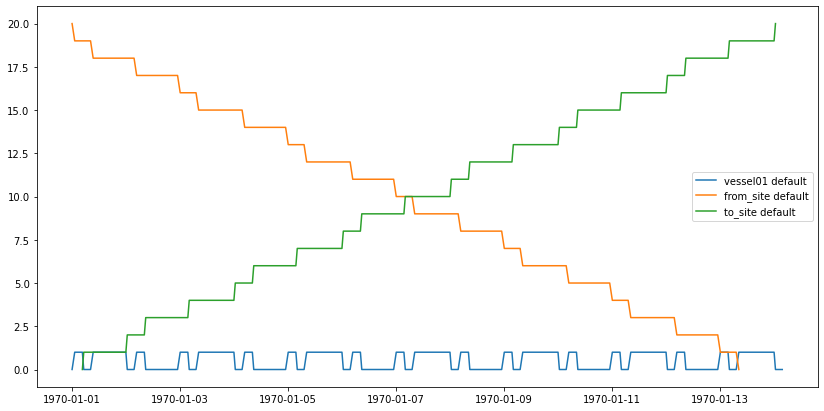

In [13]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

In [14]:
timestamp = datetime.datetime.fromtimestamp(488.9689178271081)

# Between 00:00 and 07:00
if timestamp.time() <= datetime.time(7):
    print(12)

12


In [15]:
timestamp.time()

datetime.time(0, 8, 8, 968918)